In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from climate import EarthModel
from numpy.random import exponential

### Occlusion response to one eruption

In [2]:
# Fit curve to eruption data
def fit_eruption(year, value, weights=None):
    if weights is None:
        weights = np.ones_like(value)

    # Translate eruption time to a small number greater than 0
    eps = 0.01
    t = year - year[0] + eps

    # Transform values to look like ~ 1/t
    data = value / value[-1]
    data = 1 / data
    data = data - 1

    # Find a least squares fit to the eruption curve using a 1/t function
    sol = least_squares(lambda x: weights * (x[0]/(t - x[1])**2 - data), [1, 0])

    # Transform to an "occluding" function that reduces incoming radiation
    # for time in seconds since the eruption
    def phi(t):
        # Function was fit in years.
        t = t / 365.25 / 24 / 3600
        return 1 / (sol.x[0]/(t - sol.x[1])**2 + 1)

    return phi

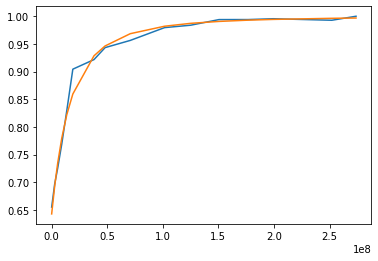

In [3]:
# Eruption 1 fit
df = pd.read_csv('./eruption_1.csv')
year = df['date'].values
value = df['value'].values
phi_1 = fit_eruption(year, value)
# Shift time to 0 and convert to seconds
t = (year - year[0]) * 365.25 * 24 * 3600
fig, ax = plt.subplots()
ax.plot(t, value / value[-1])
ax.plot(t, phi_1(t))

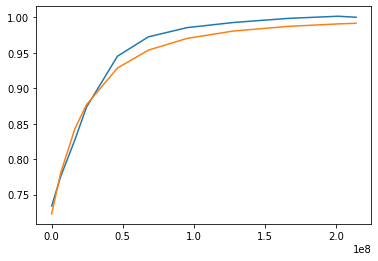

In [4]:
# Eruption 2 fit
df = pd.read_csv('./eruption_2.csv')
year = df['date'].values
value = df['value'].values
phi_2 = fit_eruption(year, value)

# Shift time to 0 and convert to seconds
t = (year - year[0]) * 365.25 * 24 * 3600
fig, ax = plt.subplots()
ax.plot(t, value / value[-1])
ax.plot(t, phi_2(t))

In [5]:
# Take phi as the average of the two fits
phi = lambda t: 0.5 * (phi_1(t)  + phi_2(t))

Text(0, 0.5, '$\\phi(t)$')

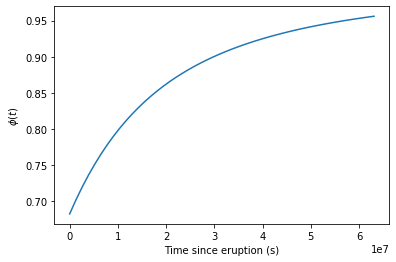

In [6]:
# Plot final function
fig, ax = plt.subplots()
years = 2
t = np.linspace(0, years * 365.25 * 24 * 3600)
ax.plot(t, phi(t))
ax.set_xlabel('Time since eruption (s)')
ax.set_ylabel('$\phi(t)$')

### Spatial component of eruption

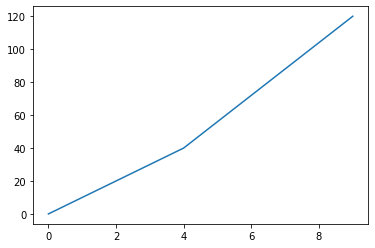

In [7]:
# Apply spatial variability to phi
x = [0,40,120]
t = [0,4,9]
plt.plot(t,x)

# Rate for the first line is 10 degrees per month (up to 40 degrees traveled)
# Rate for the second line is 18 degrees per month

# A lagged occlusion function for zones delta_k away from the eruption.
def lagged_phi(delta_k):
    lag_0 = 0
    # Lag 1: 30 degrees traveled
    lag_1 = 3 # months
    # Lag 2: 30 additional degrees traveled (10 at rate 1, 20 at rate 2)
    lag_2 = lag_1 + 1 + 20 / 18
    # The remaining lag times follow the rate from the second line
    lag_3 = lag_2 + 30 / 18
    lag_4 = lag_3 + 30 / 18
    lag_5 = lag_4 + 30 / 18
    # Convert to seconds
    lags = np.array([lag_0, lag_1, lag_2, lag_3, lag_4, lag_5]) / 12 * 365.25 * 24 * 3600

    return lambda t: phi(t) if t >= lags[delta_k] else 1.0

# Create phi for each zone when an eruption occurs in a given zone at a given time
def eruption(zone, time):
    if zone == 0:
        return lambda t: np.array([
            lagged_phi(0)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(3)(t - time),
            lagged_phi(4)(t - time),
            lagged_phi(5)(t - time)
        ])
    elif zone == 1:
        return lambda t: np.array([
            lagged_phi(1)(t - time),
            lagged_phi(0)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(3)(t - time),
            lagged_phi(4)(t - time)
        ])
    elif zone == 2:
        return lambda t: np.array([
            lagged_phi(2)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(0)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(3)(t - time)
        ])
    elif zone == 3:
        return lambda t: np.array([
            lagged_phi(3)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(0)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(2)(t - time)
        ])
    elif zone == 4:
        return lambda t: np.array([
            lagged_phi(4)(t - time),
            lagged_phi(3)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(0)(t - time),
            lagged_phi(1)(t - time)
        ])
    elif zone == 5:
        return lambda t: np.array([
            lagged_phi(5)(t - time),
            lagged_phi(4)(t - time),
            lagged_phi(3)(t - time),
            lagged_phi(2)(t - time),
            lagged_phi(1)(t - time),
            lagged_phi(0)(t - time)
        ])

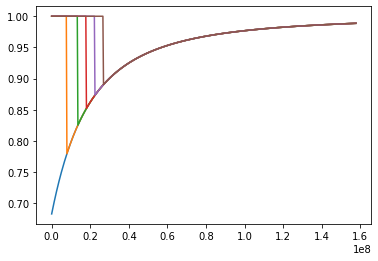

In [8]:
# Plot occluded zones
fig, ax = plt.subplots()
years = 5
ts = np.linspace(0, years * 365.25 * 24 * 3600, 500)
eruption_time = 1 * 365.25 * 24 * 3600
occlusion = eruption(0, 0)
ax.plot(ts, np.array([occlusion(t)[0] for t in ts]))
ax.plot(ts, np.array([occlusion(t)[1] for t in ts]))
ax.plot(ts, np.array([occlusion(t)[2] for t in ts]))
ax.plot(ts, np.array([occlusion(t)[3] for t in ts]))
ax.plot(ts, np.array([occlusion(t)[4] for t in ts]))
ax.plot(ts, np.array([occlusion(t)[5] for t in ts]))

### Time component of multiple eruptions

In [9]:
df = pd.read_csv('E3WebApp_Eruptions1960.csv')
df = df[df.StartDateYear > 1959]
dates = df['StartDate'].values

#Drop duplicates
df2 = df.drop_duplicates(subset=['VolcanoNumber'])
lat = df2['LatitudeDecimal'].values

#Count latitude occurrences
value_counts = df['LatitudeDecimal'].value_counts(dropna=True, sort=True)
df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['Latitude', 'Counts']

#Find number of volcanoes per zone
def Zones_func(df_value_counts):
    zone1 = []
    zone2 = []
    zone3 = []
    zone4 = []
    zone5 = []
    zone6 = []
    zone1_erc = []
    zone2_erc = []
    zone3_erc = []
    zone4_erc = []
    zone5_erc = []
    zone6_erc = []
    for i in range(len(df_value_counts)):
        if df_value_counts.iloc[i][0] > 60:
            zone6.append(df_value_counts.iloc[i][0])
            zone6_erc.append(df_value_counts.iloc[i][1])
        if df_value_counts.iloc[i][0] > 30 and df_value_counts.iloc[i][0] < 60:
            zone5.append(df_value_counts.iloc[i][0])
            zone5_erc.append(df_value_counts.iloc[i][1])
        if df_value_counts.iloc[i][0] > 0 and df_value_counts.iloc[i][0] <30:
            zone4.append(df_value_counts.iloc[i][0])
            zone4_erc.append(df_value_counts.iloc[i][1])
        if df_value_counts.iloc[i][0] <0 and df_value_counts.iloc[i][0] >-30:
            zone3.append(df_value_counts.iloc[i][0])
            zone3_erc.append(df_value_counts.iloc[i][1])
        if df_value_counts.iloc[i][0] <-30 and df_value_counts.iloc[i][0]>-60:
            zone2.append(df_value_counts.iloc[i][0])
            zone2_erc.append(df_value_counts.iloc[i][1])
        if df_value_counts.iloc[i][0] <-60 and df_value_counts.iloc[i][0]>-90:
            zone1.append(df_value_counts.iloc[i][0])
            zone1_erc.append(df_value_counts.iloc[i][1])
    volc_num = [len(zone1),len(zone2),len(zone3),len(zone4),len(zone5),len(zone6)]
    return (volc_num,zone1,zone2,zone3,zone4,zone5,zone6,zone1_erc,zone2_erc,zone3_erc,zone4_erc,zone5_erc,zone6_erc)

Zones = Zones_func(df_value_counts)
#Number of volcanoes per zone
volc = Zones[0]
#Volcano latitudes
Zone1 = Zones[1]
Zone2 = Zones[2]
Zone3 = Zones[3]
Zone4 = Zones[4]
Zone5 = Zones[5]
Zone6 = Zones[6]
Zone1e = np.sum(Zones[7])
Zone2e = np.sum(Zones[8])
Zone3e = np.sum(Zones[9])
Zone4e = np.sum(Zones[10])
Zone5e = np.sum(Zones[11])
Zone6e = np.sum(Zones[12])

In [10]:
# Find average repose time per zone (mind we're neglecting the eruption length)
t_tot = (45 + 7/12 + 8/365.25)*365.25*24*3600
t_tot_yr = (45 + 7/12 + 8/365.25)

# Zonal average repose time (in yrs)
Zone_av_yr = []
for i in range(7,13):
    Zone_av_yr.append(np.sum(Zones[i])/t_tot_yr)

# Zonal average repose time (in s)
Zone_av_s = []
for i in range(7,13):
    Zone_av_s.append(np.sum(Zones[i])/t_tot)

In [11]:
repose_time_yrs = 1 / np.array(Zone_av_yr)
repose_time = 1 / np.array(Zone_av_s)

In [12]:
def decrease_function(eruption):
    def decrease(t):
        return np.ones(6) - eruption(t)
    return decrease

def compose_eruptions(eruptions):
    decrease_functions = [decrease_function(eruption) for eruption in eruptions]
    def composed_eruptions(t):
        total_decrease = np.sum([decrease(t) for decrease in decrease_functions], axis=0)
        for i, decrease in enumerate(total_decrease):
            if decrease > 1:
                total_decrease[i] = 1
        return np.ones(6) - total_decrease
    return composed_eruptions

def zone_eruptions(tf, Zone_av_s):
    repose_time = 1 / np.array(Zone_av_s)
    eruptions = []
    for zone in range(6):
        num_zone_eruptions = int(Zone_av_s[zone] * tf)
        for i in range(num_zone_eruptions):
            eruptions.append(eruption(zone, i * repose_time[zone]))
    return compose_eruptions(eruptions)  

In [131]:
erp_exp = np.random.exponential(Zone_av_s)
tf = 20 # years
eruptions = zone_eruptions(tf * 3.154e+7, erp_exp)
eruptions(100 * 3.154e+7)

array([0.94176671, 0.94176671, 0.94176671, 0.94176671, 0.94176671,
       0.94176671])

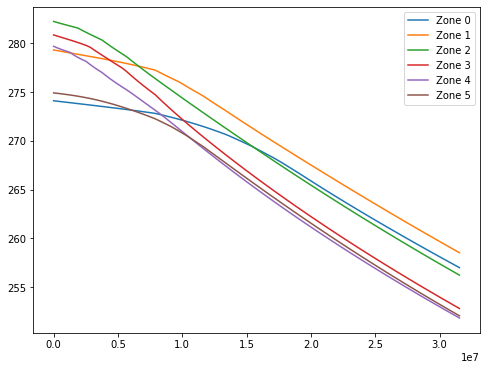

In [132]:
model = EarthModel('parameters.json')
# model.k12 = 0
# model.k23 = 0
# model.k34 = 0
# model.k45 = 0
# model.k56 = 0
model.t0 = 0
model.tf = 1 * 3.154e+7 # Years
model.tn = 100
model.method = 'vode'
model.T0 = [274.12, 279.34, 282.26, 280.88, 279.71, 274.93]
# model.T0 = [200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
model.set_occlusion(eruptions)
# model.set_occlusion(lambda t: eruption(3, 0)(t) * eruption(0, 1 * 365.25 * 24 * 3600)(t))
model.build_ode(lambda t, T: model.flux_balance_t(t, T))
model.solve()

# Plot solution
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(model.size):
    ax.plot(model.t, model.T[:, i], label='Zone {}'.format(i))
ax.legend()

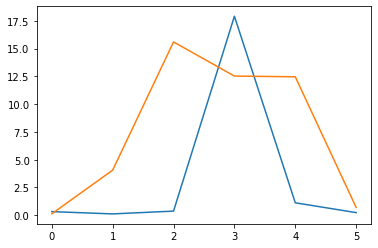

In [110]:
#Random sampling with Poisson distribution

rep_exp = np.random.exponential(repose_time)
erp_exp = np.random.exponential(Zone_av_yr)

plt.plot(erp_exp)
plt.plot(Zone_av_yr)